In [1]:
import omembrane as omem
import openmm as mm
from openmm import unit as u
import numpy as np
import math
from matplotlib import pyplot as plt

In [2]:
upper_composition={'POPC':100}
lower_composition={'POPC':100}

In [3]:
length_x, length_y = omem.build.get_membrane_size_from_composition(lower_composition, upper_composition)

In [4]:
print(length_x, length_y)

82.64381404557754 A 82.64381404557754 A


In [5]:
upper_lipid_radius = []
upper_lipid_type = []
n_upper_lipids = 0
    
for name, nn in upper_composition.items():
        
    upper_lipid_type += [name for ii in range(nn)]
    upper_lipid_radius += [omem.lipid.get_radius(name) for ii in range(nn)]
    n_upper_lipids += nn

lower_lipid_radius = []
lower_lipid_type = []
n_lower_lipids = 0
    
for name, nn in lower_composition.items():
        
    lower_lipid_type += [name for ii in range(nn)]
    lower_lipid_radius += [omem.lipid.get_radius(name) for ii in range(nn)]
    n_lower_lipids += nn

In [6]:
upper_positions = omem.build.get_initial_random_seeds_leaf(upper_lipid_radius, length_x, length_y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.00it/s]


In [7]:
lower_positions = omem.build.get_initial_random_seeds_leaf(lower_lipid_radius, length_x, length_y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.53it/s]


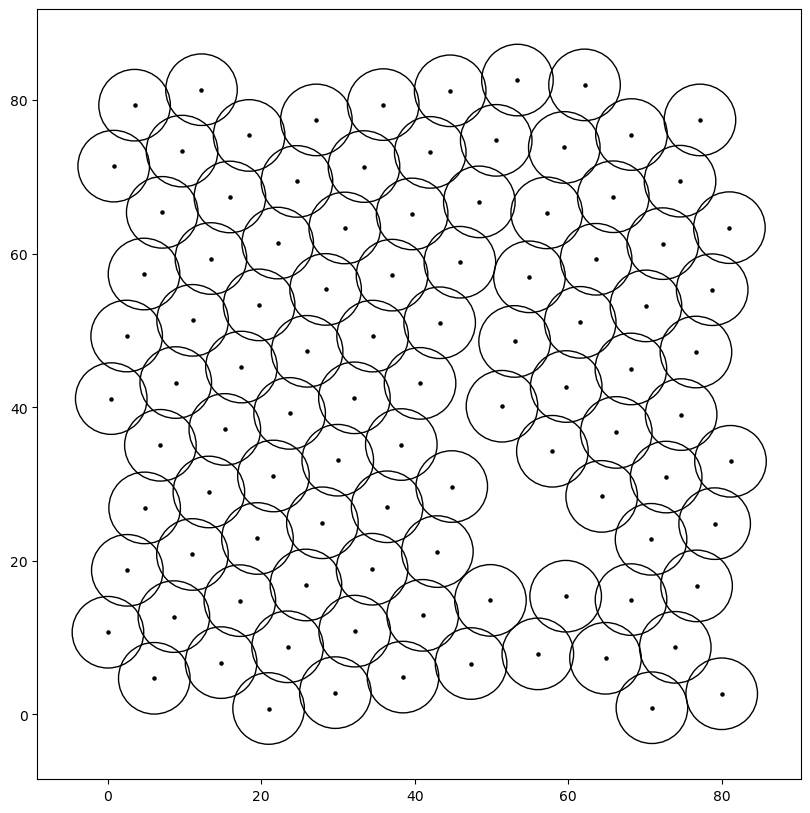

In [8]:
plt.rcParams["figure.figsize"] = (10,10)

ax=plt.gca()
for ii in range(n_upper_lipids):
    ax.add_patch(plt.Circle(10.0*upper_positions[ii,:]._value, radius= upper_lipid_radius[ii]._value, color='k', fill=False))

plt.scatter(10.0*upper_positions[:,0]._value, 10.0*upper_positions[:,1]._value, s=5, c='k')

plt.axis('scaled')

plt.show()

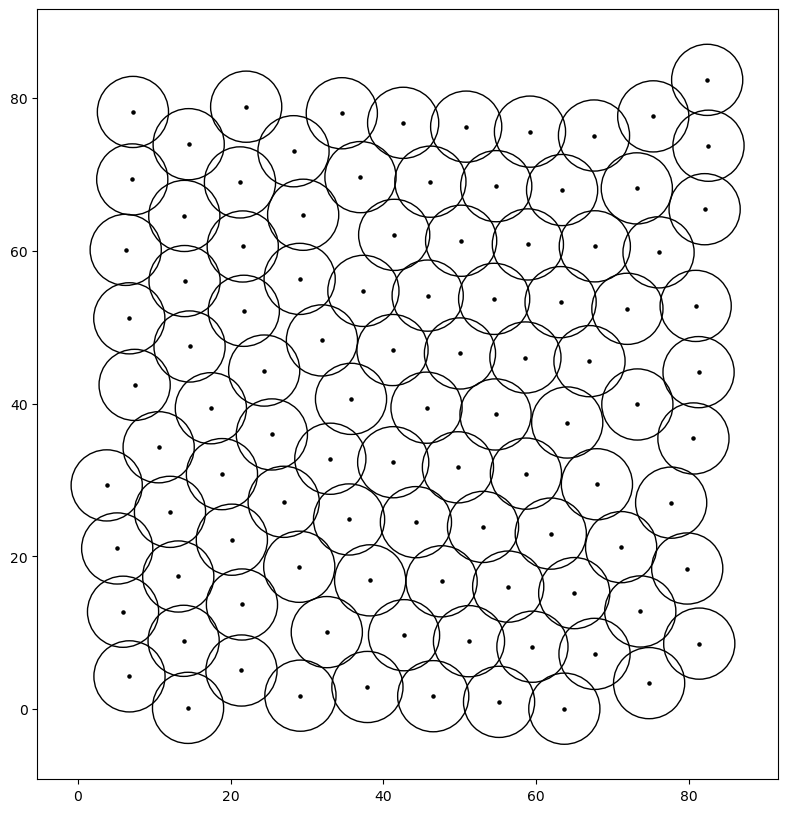

In [9]:
plt.rcParams["figure.figsize"] = (10,10)

ax=plt.gca()
for ii in range(n_lower_lipids):
    ax.add_patch(plt.Circle(10.0*lower_positions[ii,:]._value, radius= lower_lipid_radius[ii]._value, color='k', fill=False))
    
plt.scatter(10.0*lower_positions[:,0]._value, 10.0*lower_positions[:,1]._value, s=5, c='k')

plt.axis('scaled')

plt.show()